In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
current_path = os.getcwd()
parent_directory = os.path.dirname(current_path)
sys.path.append(parent_directory)
from Class.jenie import Jenie
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from umap import UMAP
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ParameterGrid

In [3]:
plt.style.use('dark_background')

In [4]:
xenium_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Xenium_mouse_filtered.h5ad")
xenium_scdata

AnnData object with n_obs × n_vars = 547139 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names', 'celltype'
    uns: 'Sample ID_colors', 'cell_id_colors', 'celltype_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
xenium_scdata.uns['neighbors']

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'method': 'umap',
  'metric': 'euclidean',
  'n_neighbors': 20,
  'random_state': 0,
  'use_rep': 'X_umap'}}

In [6]:
xenium_scdata.X = xenium_scdata.X.toarray()
xenium_scdata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.35279253,
        0.        ],
       ...,
       [0.44123012, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [7]:
xenium_c24m2 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'C24m2']
xenium_c24m2.X

ArrayView([[0.        , 0.44123012, 0.        , ..., 0.        ,
            0.5143213 , 0.        ],
           [0.35279253, 0.5617012 , 0.35279253, ..., 0.        ,
            0.        , 0.        ],
           [0.54960513, 0.35279253, 0.        , ..., 0.        ,
            0.        , 0.35279253],
           ...,
           [0.35279253, 0.        , 0.        , ..., 0.        ,
            0.44123012, 0.        ],
           [0.        , 0.48600015, 0.        , ..., 0.        ,
            0.35279253, 0.        ],
           [0.        , 0.        , 0.        , ..., 0.        ,
            0.        , 0.35279253]], dtype=float32)

# Ingest based on 'MERFISH celltype'

In [26]:
adata_merfish

AnnData object with n_obs × n_vars = 54061 × 30
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names', 'celltype', 'MERFISH celltype'
    uns: 'Sample ID_colors', 'cell_id_colors', 'celltype_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'MERFISH celltype_colors'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap', 'rep'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
adata_ref = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Gellyfish Analysis\CBM2_new_immmature_dg.h5ad")
adata = xenium_c24m2
#adata.X = adata.X.toarray()
shared = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:,shared]
adata_merfish = adata[:, shared]

In [9]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.tl.ingest(adata_merfish, adata_ref, obs="MERFISH celltype")

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['

### Umap / Brain Proj for Xenium Ingest

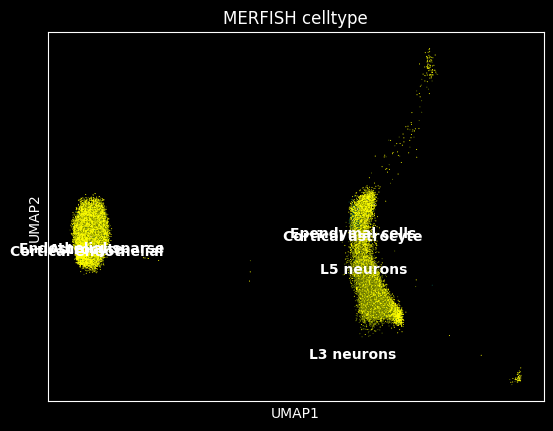

In [10]:
sc.pl.umap(adata_merfish, color = 'MERFISH celltype', legend_loc = 'on data')

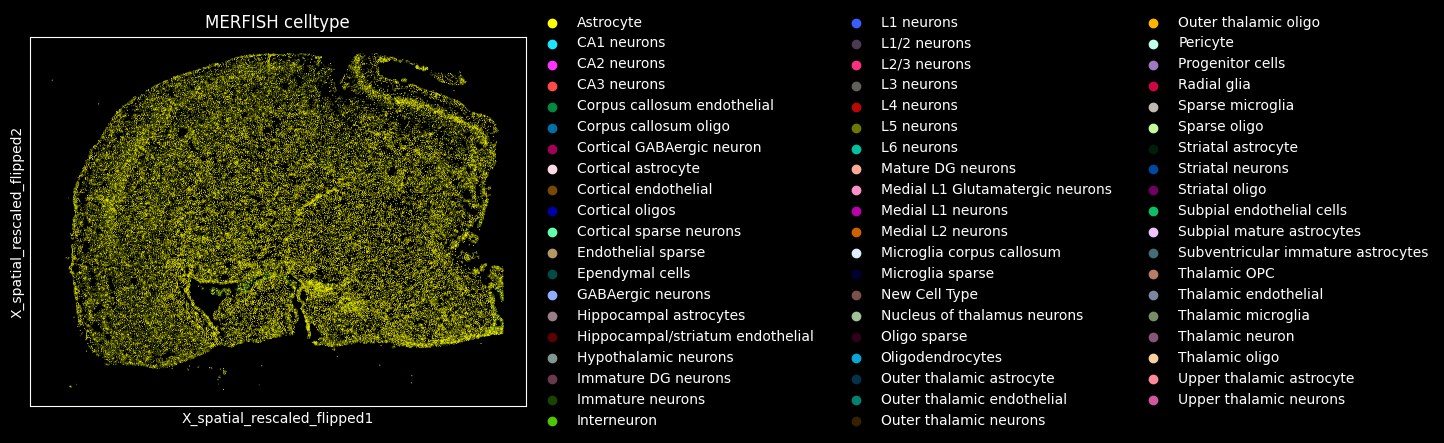

In [11]:
sc.pl.embedding(adata_merfish, basis = 'X_spatial_rescaled_flipped', color = 'MERFISH celltype')

In [12]:
adata_merfish.obs['MERFISH celltype'].value_counts()

Astrocyte                             34657
L5 neurons                            18541
Ependymal cells                         745
Endothelial sparse                       70
Cortical astrocyte                       41
Cortical endothelial                      6
L3 neurons                                1
Oligo sparse                              0
Oligodendrocytes                          0
Outer thalamic astrocyte                  0
Outer thalamic endothelial                0
Outer thalamic neurons                    0
Sparse oligo                              0
Outer thalamic oligo                      0
Pericyte                                  0
Progenitor cells                          0
Radial glia                               0
Sparse microglia                          0
Striatal neurons                          0
Striatal astrocyte                        0
New Cell Type                             0
Striatal oligo                            0
Subpial endothelial cells       

### Umap / Brain Proj for Cbm2

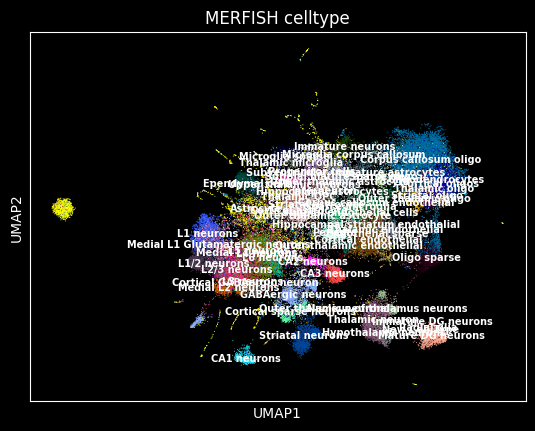

In [13]:
sc.pl.umap(adata_ref, color = 'MERFISH celltype', legend_loc = 'on data', legend_fontsize = 7)

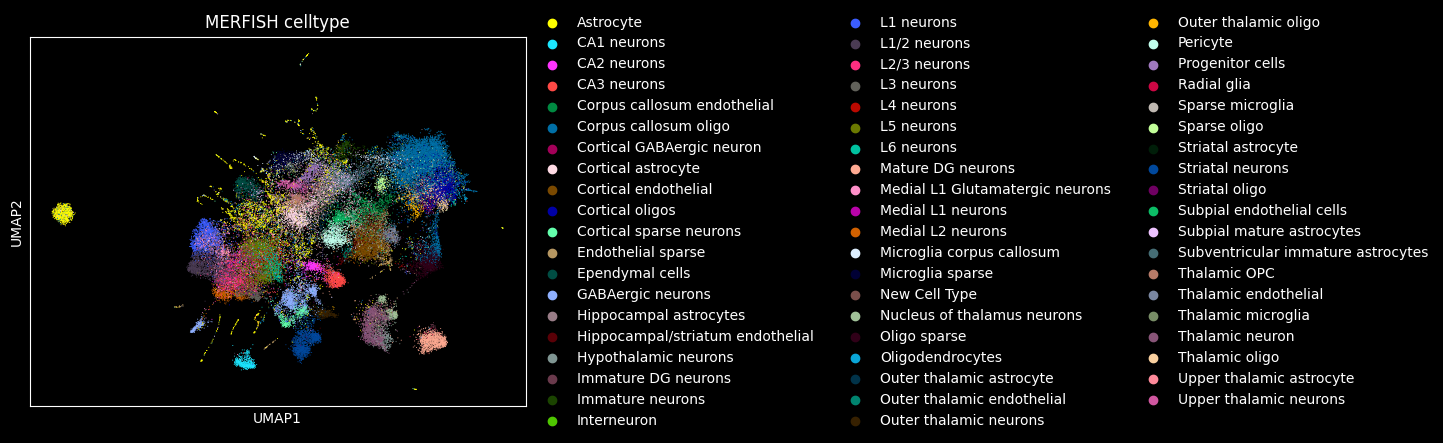

In [14]:
sc.pl.umap(adata_ref, color = 'MERFISH celltype')

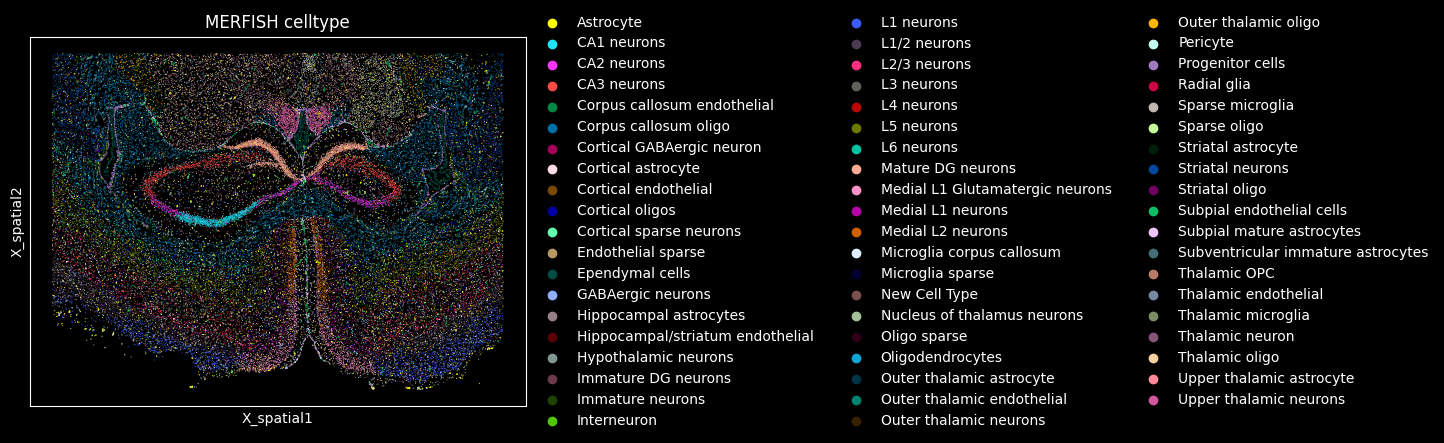

In [15]:
sc.pl.embedding(adata_ref, basis = 'X_spatial', color = 'MERFISH celltype')

In [16]:
adata_ref.obs['MERFISH celltype'].value_counts()

Corpus callosum oligo                 7430
Astrocyte                             3399
L5 neurons                            3107
L1/2 neurons                          1993
Cortical endothelial                  1919
Cortical astrocyte                    1796
Thalamic neuron                       1710
GABAergic neurons                     1710
Cortical oligos                       1670
Striatal neurons                      1616
L1 neurons                            1562
L2/3 neurons                          1464
Subventricular immature astrocytes    1358
Mature DG neurons                     1353
Oligo sparse                          1182
Hippocampal astrocytes                1145
Pericyte                              1087
Thalamic OPC                          1029
Subpial endothelial cells             1013
Medial L1 Glutamatergic neurons       1009
Ependymal cells                        970
Upper thalamic neurons                 968
CA3 neurons                            963
Thalamic ol

# Ingest based on 'general_celltype'

In [17]:
adata_ref = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Gellyfish Analysis\CBM2_new_immmature_dg.h5ad")
adata = xenium_c24m2
#adata.X = adata.X.toarray()
shared = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:,shared]
adata_general = adata[:, shared]

In [18]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.tl.ingest(adata_general, adata_ref, obs="general_celltype")

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['

### Umap / Brain Proj for Xenium Ingest

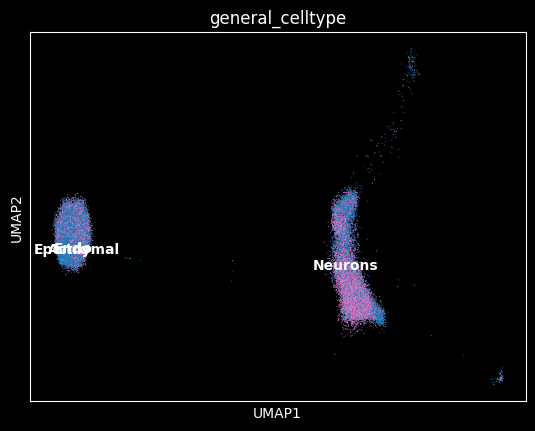

In [19]:
sc.pl.umap(adata_general, color = 'general_celltype', legend_loc = 'on data')

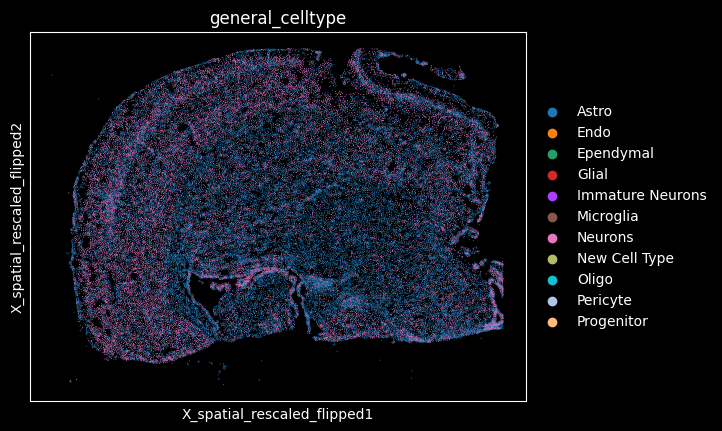

In [20]:
sc.pl.embedding(adata_general, basis = 'X_spatial_rescaled_flipped', color = 'general_celltype')

In [21]:
adata_general.obs['general_celltype'].value_counts()

Astro               34715
Neurons             19244
Endo                   75
Ependymal              27
Glial                   0
Immature Neurons        0
Microglia               0
New Cell Type           0
Oligo                   0
Pericyte                0
Progenitor              0
Name: general_celltype, dtype: int64

### Umap / Brain Proj for Cbm2

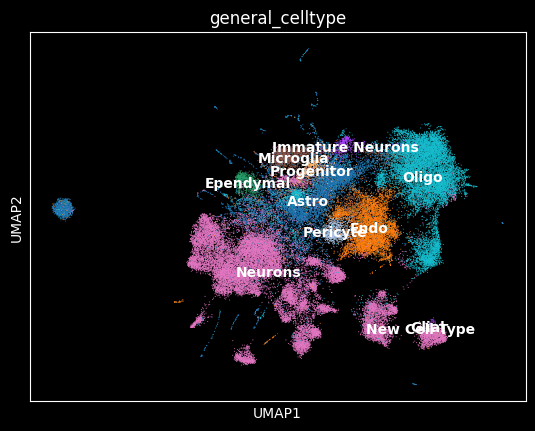

In [22]:
sc.pl.umap(adata_ref, color = 'general_celltype', legend_loc = 'on data')

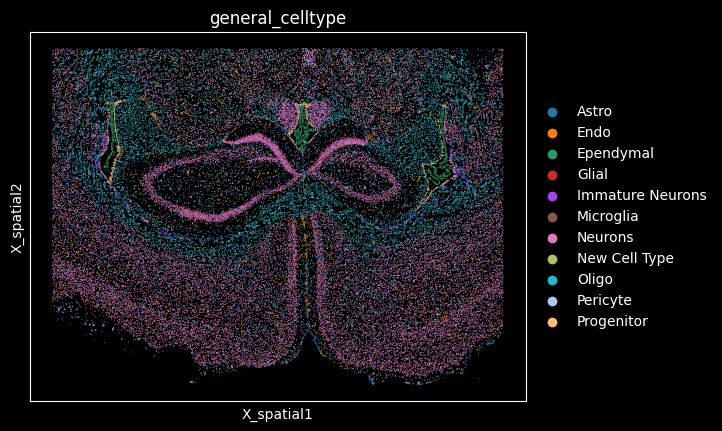

In [23]:
sc.pl.embedding(adata_ref, basis = 'X_spatial', color = 'general_celltype')

In [24]:
adata_ref.obs['general_celltype'].value_counts()

Neurons             23607
Oligo               13493
Astro                9114
Endo                 5944
Microglia            1875
Pericyte             1087
Ependymal             970
Progenitor            826
Immature Neurons      505
New Cell Type          44
Glial                  24
Name: general_celltype, dtype: int64